# Talktorial 3

# Molecular filtering: unwanted substructures

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Maximilian Driller and  Sandra Krüger

## Aim of this talktorial

There are some substructures we prefer not to enclose into our screening library. In this talktorial, we learn about different types of such unwanted substructures and how to find and highlight them with RDKit.

## Learning goals

### Theory

* What are unwanted substructures?
* Pan Assay Interference Compounds (PAINS)  

### Practical

* Read a set of compounds from ChEMBL database (prepared in **talktorial 2**)
* Filter out unwanted substructures as implemented in RDKit
* Provide your own list of unwanted substructures and filter your data based on them
* Search and highlight substructures

## References

* Brenk et al.: "Lessons learnt from assembling screening libraries for drug discovery for neglected diseases" <i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444 (https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)
* Brenk et al.: SMARTS definitions of unwanted groups (Table 1 of the Supporting
  information of <i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444 (https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)
* Baell et al.: "New substructure filters for removal of Pan Assay Interference Compounds (PAINS) from screening libraries and for their exclusion in bioassays" <i>J. Med. Chem.</i> (2010), <b>53(7)</b>,2719-2740 (https://pubs.acs.org/doi/abs/10.1021/jm901137j)
* Conversion of PAINS format from SLN (Baell et al. publication) to SMARTS by Rajarshi Guha: http://blog.rguha.net/?p=850; SMARTS that are used in the RDKit are the ones curated by Greg Landrum from Rajarshi Guha's KNIME workflow: http://rdkit.blogspot.com/2015/08/curating-pains-filters.html
* https://en.wikipedia.org/wiki/Pan-assay_interference_compounds
* TDT -Tutorial2014 - (https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb)

_____________________________________________________________________________________________________________________


## Theory

### Unwanted substructures

Substructures can be unfavorable, e.g. because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays.
Nowadays, drug discovery often involves high throughput screening ([HTS wikipedia](https://en.wikipedia.org/wiki/High-throughput_screening)). Filtering unwanted substructures can support assembling more efficient screening libraries. Hence, reducing a library before screening can save time and resources. 

Brenk *et al.* ([<i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) have constructed a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. 
Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). 

This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.

### Pan Assay Interference Compounds (PAINS)

#### General information
PAINS ([PAINS wikipedia](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds)) are compounds that often occur as hits in HTS even though they actually are false positives. PAINS tend to react unspecifically with numerous targets rather than one specific target. Apparent binding in various assays and against a range of proteins is usually due to unspecific binding or interaction with assay components.
[![PAINS](./images/PAINS_Figure.jpeg)](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif)
    <div align="center">Figure 1: Specific and unspecific binding in the context of Pan Assay Interference Compounds. Figure is taken from [wikipedia](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif). </div>

#### Filtering in the paper of Baell et al. 

Baell *et al.* ([<i>J. Med. Chem.</i> (2010), <b>53(7)</b>,2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.

## Practical

### Load and visualize data

First, we import the required libraries, load our filtered dataset from **talktorial T2**, and draw the first molecules.

In [1]:
import pandas
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt

In [2]:
filteredData = pandas.read_csv("../data/T2/EGFR_compounds_lipinski.csv", delimiter=";", index_col=0)
filteredData.drop(['HBD','HBA','MW','LogP'], inplace=True, axis=1) # Drop unnecessary information
print ('Dataframe shape: ', filteredData.shape) # Print dimension of the dataframe
filteredData.head(5)

Dataframe shape:  (4009, 6)


,molecule_chembl_id,units,IC50,pIC50,smiles,rule_of_five_conform
0,CHEMBL63786,nM,0.003,11.522879,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,yes
1,CHEMBL53711,nM,0.006,11.221849,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,yes
2,CHEMBL35820,nM,0.006,11.221849,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,yes
3,CHEMBL53753,nM,0.008,11.096910,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,yes
4,CHEMBL66031,nM,0.008,11.096910,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,yes


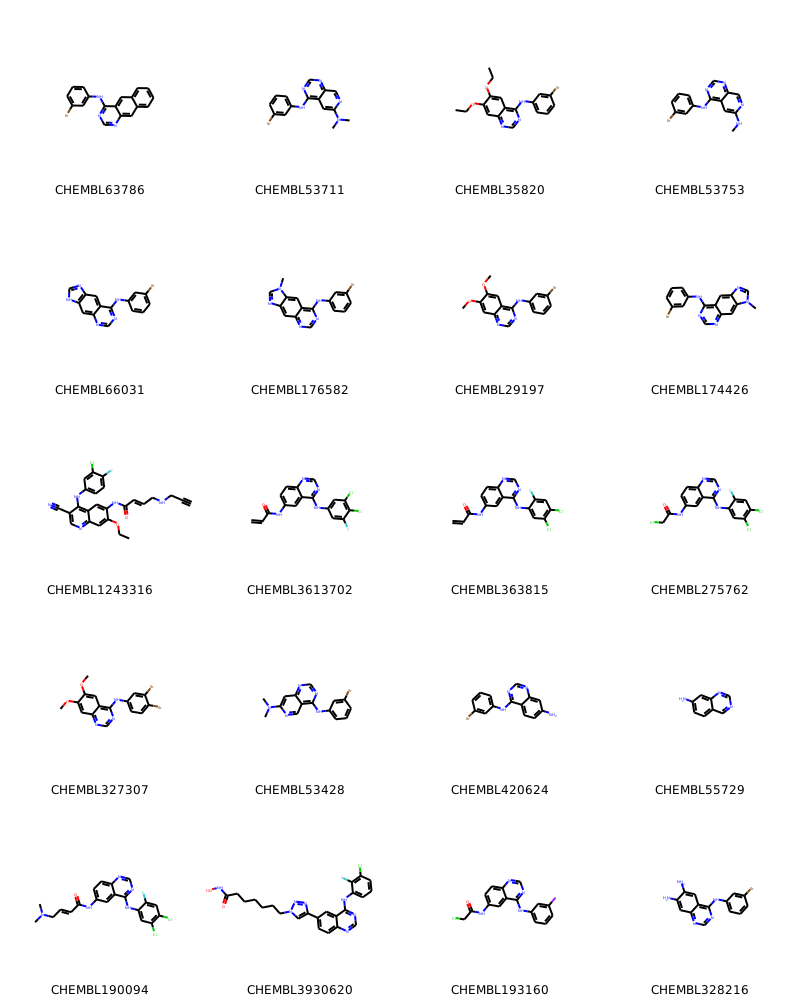

In [3]:
PandasTools.AddMoleculeColumnToFrame(filteredData, smilesCol='smiles') # Add molecule column
# Draw first 20 molecules
Draw.MolsToGridImage(list(filteredData.ROMol[0:20]), 
                    legends=list(filteredData.molecule_chembl_id[0:20]), 
                    molsPerRow=4) 

### Filtering for PAINS using RDKit

The PAINS filter is already implemented in RDKit ([RDKit Documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)), let's learn how it can be used.

In [4]:
from rdkit.Chem.FilterCatalog import *
params = FilterCatalogParams()
# Build a catalog from all PAINS (A, B and C)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

Number of compounds with PAINS: 321
Number of compounds without PAINS: 3688 (=remaining compounds)


,CompID,CompMol,unwantedID
0,CHEMBL93032,,Catechol_a(92)
1,CHEMBL2029429,,Anil_di_alk_a(478)
2,CHEMBL2029428,,Anil_di_alk_a(478)
3,CHEMBL3678952,,Anil_di_alk_a(478)
4,CHEMBL3663926,,Anil_di_alk_a(478)
5,CHEMBL3663925,,Anil_di_alk_a(478)
6,CHEMBL3937385,,Anil_di_alk_a(478)
7,CHEMBL3915455,,Anil_di_alk_a(478)
8,CHEMBL3663923,,Anil_di_alk_a(478)
9,CHEMBL2437462,,Anil_di_alk_a(478)

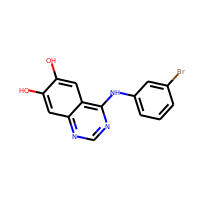
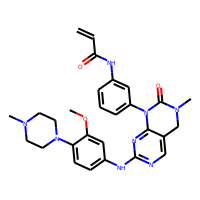
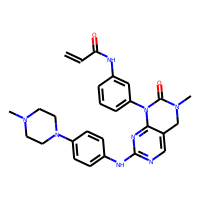
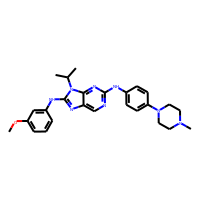
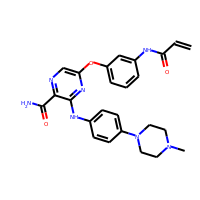
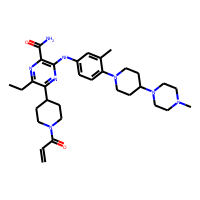
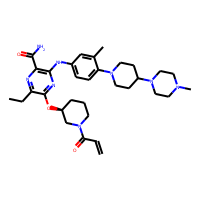
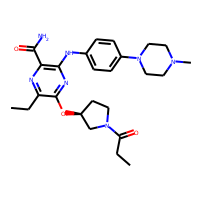
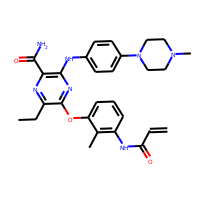
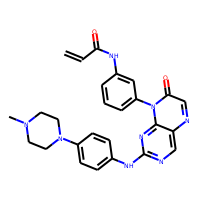

In [5]:
# Create empty dataframes for filtered data
rdkit_highLightFramePAINS = pandas.DataFrame(columns=('CompID', 'CompMol', 'unwantedID'))
rdkit_noPAINS = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles','pIC50'))
rdkit_withPAINS = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles', 'pIC50','unwantedID'))

# For index and row in the filtered df
for i,row in filteredData.iterrows():
    curMol = Chem.MolFromSmiles(row.smiles) # Current molecule
    match = False # Set match to false
    rdkit_PAINSList = []
    # Get the first match
    entry = catalog.GetFirstMatch(curMol)
    
    if entry!=None:
        # Add name of current unwanted subsftructure to list
        rdkit_PAINSList.append(entry.GetDescription().capitalize())
        # Add relevant matching information to dataframe
        rdkit_highLightFramePAINS.loc[len(rdkit_highLightFramePAINS)] = [row.molecule_chembl_id, curMol,
        entry.GetDescription().capitalize()]
        match = True
    if not match:
        # Add to frame of PAINS free compounds
        rdkit_noPAINS.loc[len(rdkit_noPAINS)] = [row.molecule_chembl_id, row.smiles, row.pIC50]
    else: 
        # Add to frame of compounds that contain PAINS
        # Put the relevant information in the dataframe with the unwanted substructures
        rdkit_withPAINS.loc[len(rdkit_withPAINS)] = [row.molecule_chembl_id, row.smiles, row.pIC50, entry.GetDescription().capitalize()]

print("Number of compounds with PAINS: %i"%(len(rdkit_withPAINS)))
print("Number of compounds without PAINS: %i (=remaining compounds)"%(len(rdkit_noPAINS)))

rdkit_highLightFramePAINS.head(10)

### Filtering for unwanted/toxic substructures (Brenk list)

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches. 
Here, we use the list provided in the supporting information by Brenk et al. ([<i>Chem. Med. Chem.</i> (2008), <b>3</b>,435-444](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).

Note, we downloaded the data and stored it as csv file in the data folder (the format is name-space-SMARTS). 
First, we load the data.

In [6]:
unwantedSubs = []
unwantedNames = []

for line in open('../data/T3/unwantedSubstructures.csv', 'r'):
    if not line.startswith("#"): # Ignore header
        splitted = line.strip().split(" ") # Split each line
        m = Chem.MolFromSmarts(splitted[1]) # Generate a molecule from smarts
        name = splitted[0].capitalize() # Store the name in name
        unwantedNames.append(name) # Append the names of the unwanted substructes to a list
        unwantedSubs.append(m) # Append the unwanted substructes to a list
print("Number of unwanted substructures in list =", len(unwantedSubs)) # Show the number of unwanted substructures

Number of unwanted substructures in list = 104


Let's have a look at a few substructures (not all SMARTS can be displayed, therefore we select a subset).

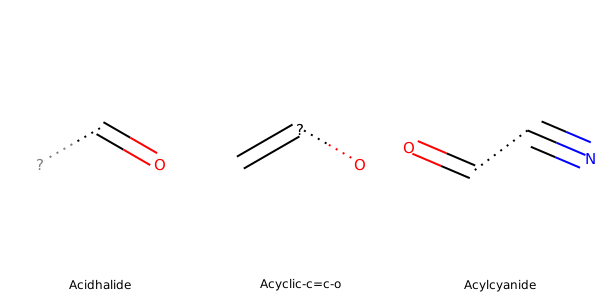

In [7]:
Chem.Draw.MolsToGridImage(list(unwantedSubs[2:5]), subImgSize=(200, 300), legends=unwantedNames[2:5])

Search our filtered dataframe for matches with these unwanted substructures.

In [8]:
# Creating dataFrames for filtered data
highLightFrameUNW = pandas.DataFrame(columns=('CompID', 'CompMol', 'unwantedID', 'unwSubstr'))
noUnwanted = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles','pIC50'))
withUnwanted = pandas.DataFrame(columns=('ChEMBL_ID', 'smiles', 'pIC50','unwantedID'))
molsToDraw = []

# For each compound in data set
for i,row in filteredData.iterrows(): # For index and row in the filtered dataframe
    curMol = Chem.MolFromSmiles(row.smiles) # Current molecule
    match = False # Set match to false
    unwantedList = []
    molsToDraw.append(curMol)
    
    # Search for all unwanted substructures
    for idx, unwSub in enumerate(unwantedSubs):
        # Check if it has the substructure
        if curMol.HasSubstructMatch(unwSub): # If the current molecule has the unwanted substructure
            match = True # Set match to True
            unwantedList.append(unwantedNames[idx]) # Add name of unwanted substructure to list
            # Put the relevant information in the dataframe
            highLightFrameUNW.loc[len(highLightFrameUNW)] = [row.molecule_chembl_id, curMol, unwantedNames[idx], unwSub]
    if not match: # If no match was found
        noUnwanted.loc[len(noUnwanted)] = [row.molecule_chembl_id, row.smiles, row.pIC50]
        # Add relevant information to dataframe of the wanted substructes
    else: # If a match was found
        withUnwanted.loc[len(withUnwanted)] = [row.molecule_chembl_id, row.smiles, row.pIC50, unwantedList] #put the relevant information in the dataframe with the unwanted substructures

print("Number of compounds with unwanted substructures: %i"%(len(withUnwanted)))
print("Number of compounds without unwanted substructures: %i (=remaining compounds)"%(len(noUnwanted)))

Number of compounds with unwanted substructures: 2058
Number of compounds without unwanted substructures: 1951 (=remaining compounds)


,CompID,CompMol,unwantedID,unwSubstr
0,CHEMBL63786,,Polycyclic-aromatic-hydrocarbon,
1,CHEMBL1243316,,Aliphatic-long-chain,
2,CHEMBL1243316,,Michael-acceptor,
3,CHEMBL1243316,,Triple-bond,

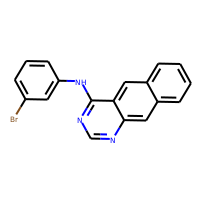
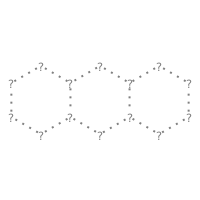
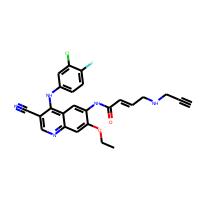
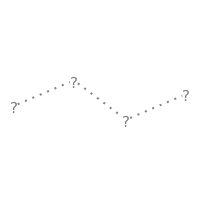
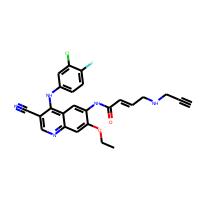
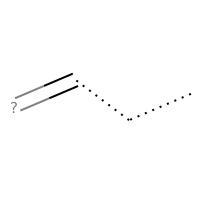
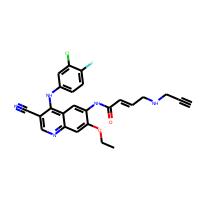
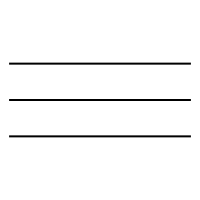

In [9]:
highLightFrameUNW.head(4)

The substructures can also be highlighted, directly within the molecule.

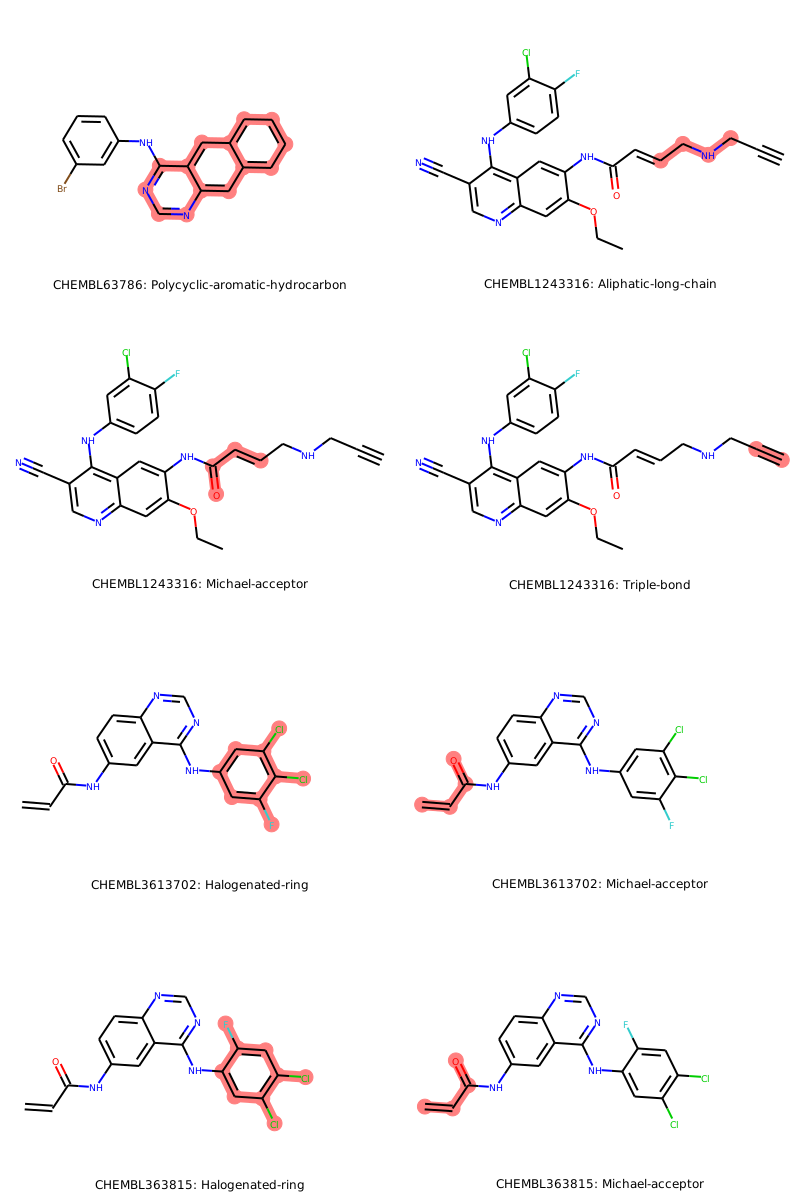

In [10]:
first_highLightFrameUNW = highLightFrameUNW.head(8) # Subset of the first 8 entries in the list

# Draw molecules and highlight the unwanted substructure 
Draw.MolsToGridImage(list(first_highLightFrameUNW["CompMol"]), subImgSize=(400,300),
    molsPerRow=2, highlightAtomLists=
    [m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])], 
    legends=list(first_highLightFrameUNW["CompID"]+": "+first_highLightFrameUNW["unwantedID"]))

We save the example as SVG file.

In [11]:
# Save image to file
img = Draw.MolsToGridImage(list(first_highLightFrameUNW["CompMol"]), subImgSize=(400,300),
    molsPerRow=3, highlightAtomLists=
    [m.GetSubstructMatch(first_highLightFrameUNW["unwSubstr"][i]) for i,m in enumerate(first_highLightFrameUNW["CompMol"])], 
    legends=list(first_highLightFrameUNW["unwantedID"]), useSVG=True)

# Get SVG data
molsvg = img.data

# Replace non-transparent to transparent background
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "24px");

# Save altered SVG data to file
f = open("../data/T3/substructures.svg", "w")
f.write(molsvg)
f.close()

The lists of compounds with and without unwanted substructures are saved.

In [12]:
# Write the compounds with unwanted substructures in a csv file
withUnwanted.to_csv("../data/T3/EGFR_compounds_lipinski_noPAINS.csv", sep=',') 

# Write the compounds without unwanted substructures in a csv file
noUnwanted.to_csv("../data/T3/EGFR_compounds_lipinski_noPAINS_noBrenk.csv", sep=',') 

# Show the head of the csv file with the compounds with the unwanted substructures i a csv file
noUnwanted.head() 

,ChEMBL_ID,smiles,pIC50
0,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL176582,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc12,11.000000


The unwanted substructures found are further analyzed.

In [13]:
# Count the most frequent compounds
unwCounts = {}
for ele in highLightFrameUNW.values:
    unw = ele[2] # ID of the unwanted substructure from the dataframe highLightFrameUNW
    if unwCounts.get(unw, "empty") == "empty": # If the ID of the unwanted structure is not yet in the dictionary
        unwCounts[unw] = [1, ele[3]] # Put a 1 and the unwanted structure in the dictionary
    else: # If the key (unwanted structure ID) already exists, increment the value of occurences 
        unwCounts[unw][0] += 1

frequentUNW = []
frequentUNWNames = []

# Structure of unwCounts: Dictionary with the ID as key, and the number of occurences and molecule as values
# E.g. ('acyclic-C=C-O', [7, <rdkit.Chem.rdchem.Mol object at 0x7fa58fc06710>])

# Sort the dictionary by frequencies of substructures
for key, value in sorted(unwCounts.items(), key=lambda kv: kv[1][0], reverse=True):
    frequentUNW.append(value[1]) # Substructure
    frequentUNWNames.append(key)

Draw the eight frequent substructures.

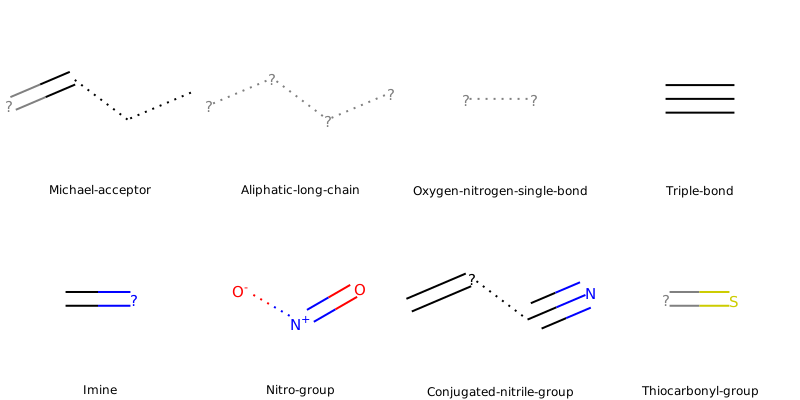

In [14]:
# Eight most frequent substructeres
Draw.MolsToGridImage(mols=list(frequentUNW[0:8]), 
                     legends=list(frequentUNWNames[0:8]),
                     molsPerRow=4)

## Discussion
In this talktorial, we learned two ways to perform a search for unwanted substructures: 
* Once with the class `FilterCatalog` which is already implemented in RDKit, and 
* Once with an external list and the `HasSubstructMatch()` function from RDKit.

Actually, PAINS could also be implemented via substructure search. And also the list by Brenk et al. is already in RDKit. Further lists that are implemented can be found in the ([RDKit Documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)). 

So far, we have been using the function `HasSubstructMatch()` which only yields one match per compound. With [`GetSubstructMatches()`](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdchem.Mol-class.html#GetSubstructMatches), we also have the option to find all substructures matching one compound.
Similarly for PAINS: We have only looked at the first match `GetFirstMatch()` per molecule. If we want to filter out all PAINS this is enough. However, we could also use `GetMatches()` in order to see all critical substructures of a molecule. Since we did not take all matches per molecule into account, we cannot state that the last substructures we drew, are actually the most frequent ones. However, they definitely do occur very often.

Detected substructures can be handled in two different ways. 
* Either, the substructure search is applied as a filter and the compounds are excluded from further testing to reduce the money and time. 
* Or, they can be used as warnings. Molecules containing unwanted substructures can be flagged. Expert's (e.g. chemists, toxicologists...) eyes might be able to judge from their experience. If the respective substructures are less critical, they might still include them for screening.

We will not filter out the unwanted substructures as we do not want to lose too many compounds for machine learning. Also, the substructure filters could still be applied in a later stage before actual experimental screening. There's the possibility to set alert flags, so the information about unfavorable substructures (according to any list, e.g. PAINS or Brenk) could be kept and considered later.

## Quiz
* Why should we consider removing "PAINS" from a screening library? What is the issue with these compounds?
* Can you find situations when some unwanted substructures would not need to be removed?
* How are the substructures we used in this tutorial encoded?